In [ ]:
import torch
import numpy as np
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

checkpoint = "/database/wuyonghuang/hsam_code/sam2-main/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"    # 这个是安装的时候写的
sam2 = build_sam2(model_cfg, checkpoint)
predictor = SAM2ImagePredictor(sam2)


In [ ]:

img = Image.open("/database/wuyonghuang/hsam_code/sam2-main/assets/model_diagram.png").convert("RGB")

with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(img)
    # masks, _, _ = predictor.predict(<input_prompts>)

In [ ]:
point_coords = np.array([[10, 10]])
point_labels = np.array([1])

masks, _, _ = predictor.predict(point_coords=point_coords, point_labels=point_labels)

In [ ]:
from PIL import Image
import numpy as np

# 假设 masks 是一个 NumPy 数组
# 如果 masks 是 PyTorch 张量，需要先转换为 NumPy 数组
if hasattr(masks, 'cpu') and hasattr(masks, 'numpy'):  # 检查是否为 PyTorch 张量
    masks_np = masks.cpu().numpy()
else:
    masks_np = masks

# 确保数据类型和值范围适合图像
# 如果是二值掩码 (0 和 1)，转换为 0-255 范围
if masks_np.dtype == bool or np.unique(masks_np).size <= 2:
    masks_np = masks_np.astype(np.uint8) * 255
elif masks_np.dtype != np.uint8:
    # 如果是浮点型且范围在 0-1 之间
    if masks_np.dtype == np.float32 or masks_np.dtype == np.float64:
        if masks_np.max() <= 1.0:
            masks_np = (masks_np * 255).astype(np.uint8)
        else:
            masks_np = masks_np.astype(np.uint8)
    else:
        masks_np = masks_np.astype(np.uint8)

# 根据维度创建适当的图像
if len(masks_np.shape) == 2:  # 灰度图像
    masks_pil = Image.fromarray(masks_np, mode='L')
elif len(masks_np.shape) == 3 and masks_np.shape[2] == 3:  # RGB 图像
    masks_pil = Image.fromarray(masks_np, mode='RGB')
elif len(masks_np.shape) == 3 and masks_np.shape[2] == 4:  # RGBA 图像
    masks_pil = Image.fromarray(masks_np, mode='RGBA')
elif len(masks_np.shape) == 3 and masks_np.shape[2] == 1:  # 单通道图像，但有额外维度
    masks_pil = Image.fromarray(masks_np[:, :, 0], mode='L')
elif len(masks_np.shape) == 3 and masks_np.shape[0] in [1, 3, 4]:  # 可能是 CHW 格式
    # 转换为 HWC 格式
    masks_np = np.transpose(masks_np, (1, 2, 0))
    if masks_np.shape[2] == 1:
        masks_pil = Image.fromarray(masks_np[:, :, 0], mode='L')
    elif masks_np.shape[2] == 3:
        masks_pil = Image.fromarray(masks_np, mode='RGB')
    elif masks_np.shape[2] == 4:
        masks_pil = Image.fromarray(masks_np, mode='RGBA')
else:
    raise ValueError(f"Unsupported shape: {masks_np.shape}")


mask_input = np.array(masks_pil.resize((256, 256)))[..., 0][None]
print(mask_input.shape)

(1, 256, 256)


In [97]:
masks2, _, _ = predictor.predict(point_coords=np.array([[10, 10]]), point_labels=np.array([1]), mask_input=mask_input)

In [ ]:
np.unique(np.sum(masks, axis=0))    # 为什么这里是三通道呢？

array([0., 1., 2., 3.], dtype=float32)

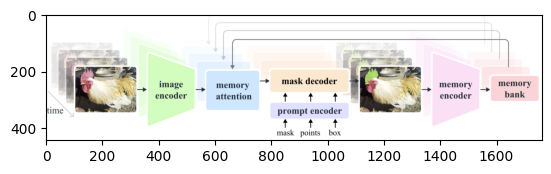

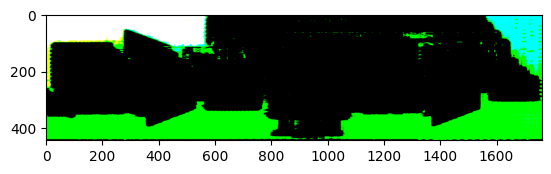

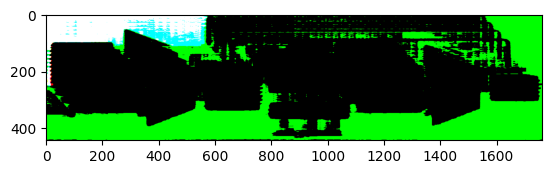

In [92]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

plt.imshow(np.transpose(masks, (1, 2, 0)))
plt.show()

plt.imshow(np.transpose(masks2, (1, 2, 0)))
plt.show()